# Imports

In [1]:
import json 
import string
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import en_core_web_sm
nlp = spacy.load("en_core_web_sm")
# stopwords = nlp.Defaults.stop_words
from spacy.lang.en.stop_words import STOP_WORDS
# stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint
from sklearn.decomposition import NMF
from sklearn import preprocessing
from nltk import ngrams
from nltk import FreqDist
from sklearn.decomposition import LatentDirichletAllocation as LDA
# nltk.download('all')
from nltk import pos_tag

In [2]:
# charts
import matplotlib.pyplot as plt
import seaborn as sns
import os
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

In [3]:
#warnings
import warnings
warnings.filterwarnings('ignore')

#options
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

In [4]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_fscore_support

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Functions

### 1. Data cleaning

In [5]:
# def remove_special_characters(text):
#     # remove_special = re.sub(r'[^a-zA-Z0-9\s]', '', text)
#     # # clean_text = re.sub('\S*\d\S*\s*', '', clean_text)
#     # remove_special = re.sub(r'[0-9]', '', text)

#     text = re.sub('\[.*\]','', text)
#     text = re.sub('\S*\d\S*\s*','', text)
#     return text

# def text_replace(text):
#     modified_text = text.replace('xx', '').replace('-PRON-', '').strip()
#     return modified_text.strip()


# def remove_punctuation(text):
#     translator = str.maketrans('', '', string.punctuation)
#     no_punctuation = text.translate(translator)

#     return no_punctuation

# def convert_to_lowercase(text):
#     text_lower = text.lower()

#     return text_lower

# def remove_stopwords(tokens):
#     token_fil = [word for word in tokens if word.lower() not in stop_words]

#     return token_fil

# def tokenize_text(text):
#     tokens = nltk.word_tokenize(text)

#     return tokens
    
    


In [6]:
def remove_special_characters(text):
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    clean_text = re.sub('\[.*\]','', text)
    clean_text = re.sub('\S*\d\S*\s*','', text)

    return clean_text

def remove_punctuation(text):
    punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return punctuation

def convert_to_lowercase(text):
    text_lower = text.lower()
    return text_lower

def token_text(text):
    tokens  = word_tokenize(text)

    return ' '.join(tokens)

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in STOP_WORDS]
    
    return ' '.join(filtered_words)

def replace(text):
    replaced = text.replace('xxxx', '').replace('-PRON-', '').replace('+', ' ')

    return replaced

def clean_cat(text):
    replaced = text.replace('+', ' ').replace('-', ' ').lower()
    punctuation = replaced.translate(str.maketrans('', '', string.punctuation))

    return punctuation

### 2. Merge cleaning functions to one function

In [7]:
def preprocess_text(text):
    # Apply preprocessing functions in a specific order
    
    text = convert_to_lowercase(text)
    text = remove_special_characters(text)
    text = remove_punctuation(text)
    text = replace(text)
    text = token_text(text)
    text = remove_stopwords(text)

    # return ' '.join(text)
    return text


In [8]:
# # nltk download - issue with ssl certyficate

# import nltk
# import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download('all')

### 3. Restore basic forms of words

In [9]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    token_lemma = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in STOP_WORDS]

    return ' '.join(token_lemma)

def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    stem_words = [stemmer.stem(word) for word in tokens if word.text.lower() not in STOP_WORDS]
    
    return ' '.join(stem_words)

def remove_pos_tags(text):
    doc = nlp(text)
    sent = [token.text for token in doc if token.tag_ == 'NN']

    return ' '.join(sent)
    

# finding ngrams

In [10]:
def get_ngrams(text, n):
    tokens = word_tokenize(text)
    n_grams = ngrams(tokens, n)
    return list(n_grams)

def get_top_ngrams(data, n, top=30):
    combined_text = ' '.join(data.astype(str))
    n_grams = get_ngrams(combined_text, n)
    freq_dist = FreqDist(n_grams)
    return freq_dist.most_common(top)

# Importing data 

### dataset - https://www.kaggle.com/datasets/abhishek14398/automatic-ticket-classification-dataset/data

In [14]:
path = "complaints.json"
open_path = open(path) 
read_data = json.load(open_path)
df=pd.json_normalize(read_data)

In [15]:
df = df[['_source.complaint_what_happened','_source.product','_source.sub_product']]
df = df.rename(columns={'_source.complaint_what_happened': 'complaint_text', '_source.product': 'category','_source.sub_product': 'sub_category'})

# data modelling
df['category'] = df['category'] + '+' + df['sub_category']
df = df.drop(['sub_category'],axis= 1)

df[df['complaint_text']==''] = np.nan
df = df[~df['complaint_text'].isnull()]

df[df['category']==''] = np.nan
df = df[~df['category'].isnull()]

# text cleaning

In [16]:

data = df # replace to have possibility to load back original data
data['complaint_text'] = data['complaint_text'].astype(str)
data['text_clean'] = data['complaint_text'].apply(lambda x: preprocess_text(x))
data['text_clean'] = data['text_clean'].apply(lambda x: lemmatize(x))
data['text_clean'] = data['text_clean'].apply(lambda x: remove_pos_tags(x))

data['category'] = data['category'].astype(str)
data['cat_clean'] = data['category'].apply(lambda x: clean_cat(x))

### Check data

(array([ 602.,  196.,   90.,  489.,  368.,  182.,  112.,  456.,  957.,
         786.,  117., 1323.,   41.,  404., 4145.,   19.,    0.,  497.,
          15.,   27.,    0.,   56.,   19.,  261.,    0.,   23.,   48.,
           0.,    0., 4937.,    0.,  221.,  344.,  108.,    0.,    0.,
          33.,    0.,    0.,    0.,    0., 2011.,    0.,    0.,    0.,
          14.,    0.,    0.,    0.,   62.]),
 array([ 20. ,  21.7,  23.4,  25.1,  26.8,  28.5,  30.2,  31.9,  33.6,
         35.3,  37. ,  38.7,  40.4,  42.1,  43.8,  45.5,  47.2,  48.9,
         50.6,  52.3,  54. ,  55.7,  57.4,  59.1,  60.8,  62.5,  64.2,
         65.9,  67.6,  69.3,  71. ,  72.7,  74.4,  76.1,  77.8,  79.5,
         81.2,  82.9,  84.6,  86.3,  88. ,  89.7,  91.4,  93.1,  94.8,
         96.5,  98.2,  99.9, 101.6, 103.3, 105. ]),
 <BarContainer object of 50 artists>)

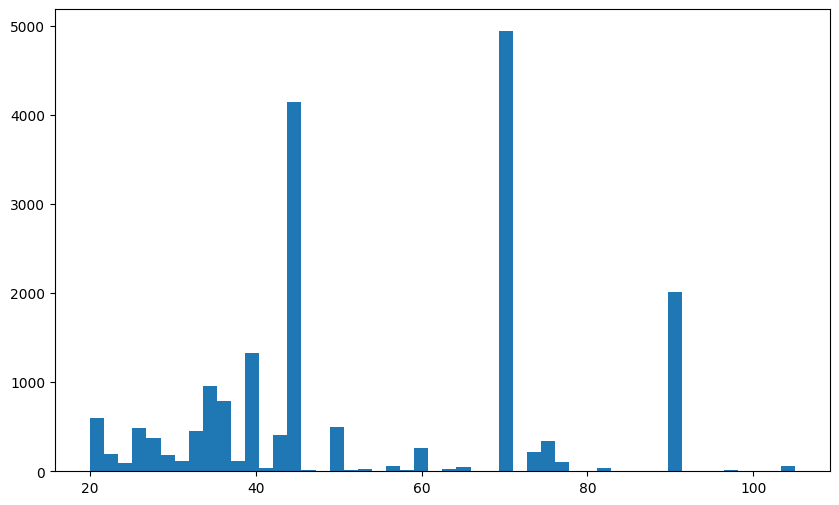

In [17]:
# Write your code here to visualise the data according to the 'Complaint' character length

plt.figure(figsize=(10,6))
# doc_lens = [len(d) for d in data['text_clean']]
doc_lens = [len(d) for d in data['cat_clean']]
plt.hist(doc_lens, bins = 50)

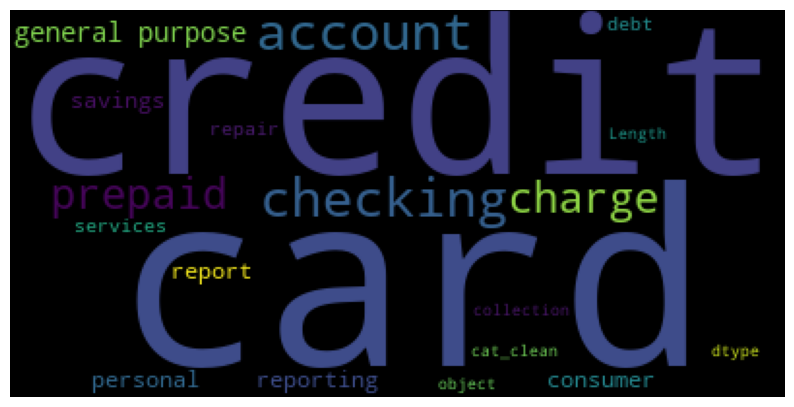

In [18]:

from wordcloud import WordCloud

# wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['text_clean']))
wordcloud = WordCloud(stopwords=STOP_WORDS, max_words=40).generate(str(data['cat_clean']))

print(wordcloud)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Topic Modelling
### in this dataset I have too much categories, so my plan is to change quantity of categories to 5.
### This can be done by NFM or LDA
###
###
###

### Finding top n-grams

In [19]:
# top_unigrams = get_top_ngrams(data['text_clean'], 1)
# top_bigrams = get_top_ngrams(data['text_clean'], 2)
# top_trigrams = get_top_ngrams(data['text_clean'], 3)

top_unigrams = get_top_ngrams(data['cat_clean'], 1)
top_bigrams = get_top_ngrams(data['cat_clean'], 2)
top_trigrams = get_top_ngrams(data['cat_clean'], 3)

print("\n top unigrams : \n", top_unigrams[:5])
print("\n top top_bigrams : \n",top_bigrams[:5])
print("\n top top_trigrams : \n",top_trigrams[:5])


 top unigrams : 
 [(('card',), 20698), (('or',), 20023), (('credit',), 17201), (('account',), 11290), (('checking',), 9320)]

 top top_bigrams : 
 [(('credit', 'card'), 10659), (('card', 'or'), 9957), (('prepaid', 'card'), 5088), (('or', 'prepaid'), 5039), (('checking', 'account'), 5030)]

 top top_trigrams : 
 [(('credit', 'card', 'or'), 9957), (('card', 'or', 'prepaid'), 5039), (('or', 'prepaid', 'card'), 5039), (('prepaid', 'card', 'general'), 4962), (('card', 'general', 'purpose'), 4962)]


### Vectorizer

In [20]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = tfidf.fit_transform(data['text_clean']) # document term metrix
dtm = tfidf.fit_transform(data['cat_clean'])
feature_names = np.array(tfidf.get_feature_names_out())

In [21]:
# model = CountVectorizer(min_df=2, max_df=0.95, stop_words='english')
# dtm = model.fit_transform(data['clean']) # document term metrix
# feature_names = np.array(model.get_feature_names_out())

### NFM

In [22]:
from sklearn.preprocessing import normalize

num_topics = 5  # You can adjust the number of topics as needed
nmf_model = NMF(n_components=num_topics, init='random', random_state=42)
nmf_matrix = nmf_model.fit_transform(dtm)

# Normalize the NMF matrix
nmf_matrix_normalized = normalize(nmf_matrix, axis=1)

# Assign topics to documents
data['topic'] = nmf_matrix_normalized.argmax(axis=1)


for topic in range(num_topics):
    topic_words_idx = nmf_model.components_[topic].argsort()[-15:][::-1]
    topic_words = [feature_names[i] for i in topic_words_idx]
    
    print(f"Top 15 words for Topic {topic}:\n")
    print(topic_words)
    print("\n")



Top 15 words for Topic 0:

['reporting', 'credit', 'personal', 'services', 'repair', 'reports', 'consumer', 'loan', 'report', 'line', 'equity', 'vehicle', 'home', 'heloc', 'lease']


Top 15 words for Topic 1:

['mortgage', 'conventional', 'home', 'fixed', 'fha', 'adjustable', 'arm', 'equity', 'line', 'loan', 'type', 'va', 'heloc', 'credit', 'vehicle']


Top 15 words for Topic 2:

['debt', 'collection', 'credit', 'card', 'know', 'auto', 'mortgage', 'loan', 'money', 'student', 'club', 'phone', 'health', 'transfer', 'private']


Top 15 words for Topic 3:

['card', 'credit', 'prepaid', 'purpose', 'general', 'charge', 'store', 'equity', 'line', 'loan', 'gift', 'home', 'benefit', 'government', 'collection']


Top 15 words for Topic 4:

['account', 'checking', 'savings', 'bank', 'service', 'product', 'banking', 'productservice', 'money', 'transfer', 'certificate', 'cd', 'deposit', 'currency', 'virtual']




In [23]:
data.topic.value_counts()

4    6741
3    5046
1    3789
0    2371
2    1016
Name: topic, dtype: int64

In [ ]:
# temp =data[['complaint_text','text_clean','category', 'cat_clean', 'topic']].groupby('topic').head(30)
# temp.sort_values('topic')

# data[data['topic'] == 'Other'].head(30)


,complaint_text,category,text_clean,cat_clean,topic
1431,"I made a reservation for an apartment on XXXX on XXXX/XXXX/17 and charged {$1600.00} on my Chase Visa credit card. I learned the next day the host was a fraud and contacted both XXXX and Chase to report the problem. Chase said they could not dispute the charge because it was still pending. I cancelled the reservation and under the XXXX policy I received a partial refund. I disputed the charge for the remaining amount with both XXXX and Chase. XXXX admitted the host was a fraud and said they were working through the issue. Chase would not agree to contact XXXX to determine if charge was fraudulent. I had the acknowledgement in writing from XXXX that the host was fraudulent. Weeks went by and Chase continued to do nothing and insisted was responsible for the charge because I knew the cancellation policy therefore I was responsible for the charge. Chase was unwilling to protect me from XXXX keeping my money for a fraudulent host. Finally after multiple emails, calls and influence from XXXX news, XXXX notified me that they would refund the remaining amount I had paid. I am actually more upset with Chase credit because they were completely unwilling to conduct any research with XXXX to assist and protect me despite the close to {$1000.00} fees I pay to Chase each year to have XXXX credit cards with their company. I contacted all the major news stations in my area because I wanted consumers to know both XXXX and Chase credits cards do not protect consumers from fraudulent hosts. In fact, XXXX is interviewing me next week on this story. I sincerely hope your organization will contact Chase and not allow this practice so that other consumers do not find themselves in the same situation.",nan,reservation apartment chase visa credit card day host fraud chase report dispute charge reservation policy refund charge chase host fraud issue chase contact determine charge acknowledgement host week charge cancellation policy charge chase protect money host email call influence news refund chase credit conduct research assist protect fee pay chase year credit card company news station consumer know chase credit card consumer host fact week story organization chase practice consumer situation,nan,Other
1441,I have a Credit Card with Case. Recently they have been an inaccurate late payment fee listed on my account that has caused my credit score to drop significantly.,nan,credit card case payment fee account credit score,nan,Other
1442,"I have a chase freedom credit card. I always pay on time and pay in-full. My last day of payment is XXXX of every month and I got late by 1 hour and Chase charged me {$25.00} fee + interest. I requested Chase by calling their customer care but they refused to help OR waive-off fee. So I end-up paying late fee but than I requested chase to set-up automatic payment on my account so that next time it does not happen. This incident happened last month in XXXX 2016. Now again on XXXX XXXX, I got lat by 1 hour and called the customer care at XXXX of XXXX XXXX ( ideally it is night of XX/XX/XXXX ) and requested them that I want to pay full bill but please remove this late fee. they refused to do that again. Now I have set-up automatic payment in my account this time. But I do not want to pay this late fee again and again for no reason. It feels like exploitation even after being a loyal costumer for last so many years. I feel it is cheating/exploitation from Chase side. I have not paid my credit card bill yet but I am very much willing to pay it in-full once CHASE remove all charges. When I spoke to CHASE customer care supervisor ( her name is XXXX and she is in OH office ) and before that spoke to a representative ( her name is : XXXX and she was very rude and that 's why I requested her to let me talk to her supervisor ). No matter what I say to them, their answer is same and something like "" Sorry we really can not help in this regard ''.",nan,chase freedom cre

In [24]:


#Create the dictionary of Topic names and Topics
# topic_mapping = {
#     0: 'Fees, Charges, and Account Balances',
#     1: 'Credit Cards, Credit Reports',
#     2: 'Other',
#     3: 'Banking and Account activities',
#     4: 'Payments, Loans, and Mortgages'
# }

topic_mapping = {
    0: 'Fees, Charges, and Account Balances',
    1: 'Payments, Loans, and Mortgages',
    2: 'Other',
    3: 'Credit Cards, Credit Reports',
    4: 'Banking and Account activities'
}

#Replace Topics with Topic Names
data['topic'] = data['topic'].map(topic_mapping)

data.to_csv('data.csv', index=False) # saving dataset

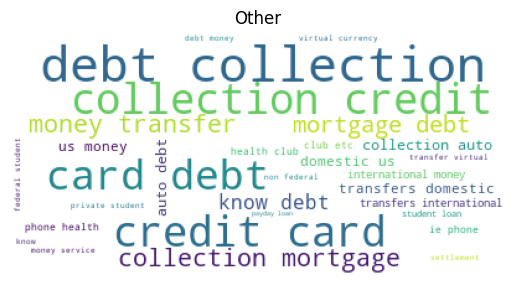

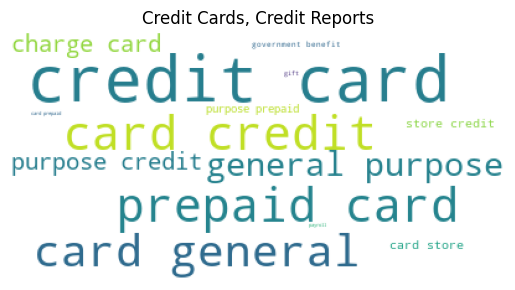

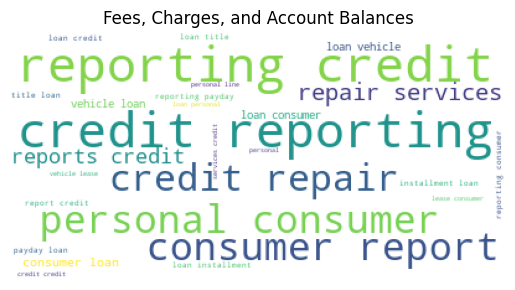

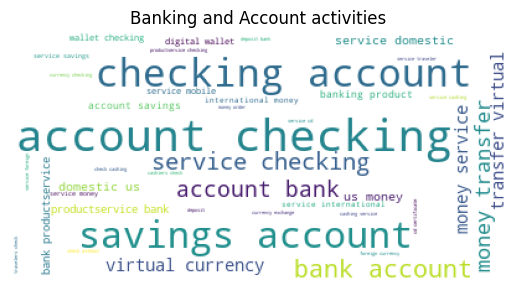

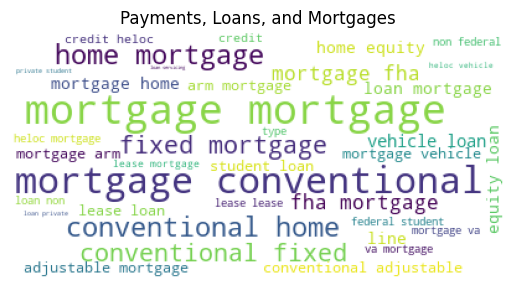

In [25]:
for x in data['topic'].unique():
	wc = WordCloud(background_color="white", max_words=100)
	# wc.generate(data['text_clean'][(data['text_clean'].notnull()) & (data['topic'] == x)].to_string())
	wc.generate(data['cat_clean'][(data['cat_clean'].notnull()) & (data['topic'] == x)].to_string())
	plt.imshow(wc)
	plt.title(x)
	plt.axis("off")
	plt.show()

In [26]:
data.topic.value_counts()

Banking and Account activities         6741
Credit Cards, Credit Reports           5046
Payments, Loans, and Mortgages         3789
Fees, Charges, and Account Balances    2371
Other                                  1016
Name: topic, dtype: int64

# importing dataset

In [51]:
data.head()

,complaint_text,category,text_clean,cat_clean,topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt,morning appreciate help bank chase debt verification statement bank validate debt mail month debt information consumer chase account advance help,debt collection credit card debt,Other
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account anniversary date consent agent,credit card or prepaid card general purpose credit card or charge card,"Credit Cards, Credit Reports"
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",card application identity consent service credit verifying identity applicant,credit reporting credit repair services or other personal consumer reports other personal consumer report,"Fees, Charges, and Account Balances"
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.","Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",book ticket offer ticket reward card information offer minute screen decision chase bank bank notification screen application state information offer credit offer account statement purchase ticket account application representative application request proceed application chase fact credit account credit report chase information credit report process application consent error,credit reporting credit repair services or other person

In [33]:
data = pd.read_csv('data.csv')

# TESTING ON DIFFERENT CLASSIFICATORS

In [52]:
training_data = data[['complaint_text','topic']]

In [43]:
# training_data['text_clean'] = training_data['text_clean'].fillna('')
# training_data[training_data['text_clean']==''] = np.nan
# training_data = training_data[~training_data['text_clean'].isnull()]

In [54]:
X = training_data['complaint_text']
y = training_data['topic']

In [55]:
cv = CountVectorizer()
X_vec = cv.fit_transform(X)

In [56]:
from sklearn.feature_extraction.text import TfidfTransformer
#Write your code here to transform the word vector to tf-idf
#Fit transform word vector to TF-IDF
tfidf_t = TfidfTransformer()
X_tfidf = tfidf_t.fit_transform(X_vec)

In [57]:
from sklearn.model_selection import train_test_split
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=40, stratify=y)

In [58]:
def display_classification_report(model):
    
    # Calculate ROC AUC scores
    y_train_pred_proba = model.predict_proba(X_train)
    y_test_pred_proba = model.predict_proba(X_test)
    roc_auc_score_train = round(roc_auc_score(y_train, y_train_pred_proba, average='weighted', multi_class='ovr'), 2)
    roc_auc_score_test = round(roc_auc_score(y_test, y_test_pred_proba, average='weighted', multi_class='ovr'), 2)
    print("ROC AUC Score Train:", roc_auc_score_train)
    print("ROC AUC Score Test:", roc_auc_score_test)

    # Calculate precision, recall, fscore, and support
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
  
    precision_train, recall_train, fscore_train, support_train = precision_recall_fscore_support(y_train, y_train_pred, average='weighted')
    precision_test, recall_test, fscore_test, support_test = precision_recall_fscore_support(y_test, y_test_pred, average='weighted')
    
    # Calculate and print accuracy scores
    acc_score_train = round(accuracy_score(y_train, y_train_pred), 2)
    acc_score_test = round(accuracy_score(y_test, y_test_pred), 2)
    
    
    print('Train Accuracy :', acc_score_train)
    print('Test Accuracy :', acc_score_test)
        
    # Print classification reports
    model_report_train = classification_report(y_train, y_train_pred)
    model_report_test = classification_report(y_test, y_test_pred)
    
    print('Classification Report for Train:\n', model_report_train)
    print('Classification Report for Test:\n', model_report_test)

    # # Plot the confusion matrix
    # fig, ax = plt.subplots(figsize=(12, 8))
    # # Create the confusion matrix
    # cm = confusion_matrix(y_test, y_test_pred)
    # cmp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    # cmp.plot(ax=ax)
    # plt.xticks(rotation=80)

    # plt.show();

    # metric.append(roc_auc_score_train)
    # metric.append(roc_auc_score_test)
    # metric.append(acc_score_train)
    # metric.append(acc_score_test)
    # metric.append(round(precision_train, 2))
    # metric.append(round(precision_test, 2))
    # metric.append(round(recall_train, 2))
    # metric.append(round(recall_test, 2))
    # metric.append(round(fscore_train, 2))
    # metric.append(round(fscore_test, 2))


In [59]:
# scaller for log reg

scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
# Logistic Regression Classification
log_reg = LogisticRegression(random_state=40,solver='liblinear')
# fit model
log_reg.fit(X_train,y_train)
# display classification report
# metric2=[]
display_classification_report(log_reg)

ROC AUC Score Train: 0.98
ROC AUC Score Test: 0.96
Train Accuracy : 0.87
Test Accuracy : 0.83
Classification Report for Train:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.89      0.95      0.92      4719
       Credit Cards, Credit Reports       0.86      0.89      0.87      3532
Fees, Charges, and Account Balances       0.77      0.67      0.72      1660
                              Other       0.86      0.46      0.60       711
     Payments, Loans, and Mortgages       0.87      0.92      0.89      2652

                           accuracy                           0.87     13274
                          macro avg       0.85      0.78      0.80     13274
                       weighted avg       0.86      0.87      0.86     13274

Classification Report for Test:
                                      precision    recall  f1-score   support

     Banking and Account activities       0.86      0.93      0.8

In [115]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

# FINAL TEST

In [144]:
data.head()

,complaint_text,category,clean,topic
0,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Debt collection+Credit card debt,morning help bank chase debt verification statement bank validate debt mail month attempt debt information consumer chase account advance help,"Payments, Loans, and Mortgages"
1,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Credit card or prepaid card+General-purpose credit card or charge card,card agent upgrade anniversary date change agent information order upgrade account change anniversary date consent recording agent mislead,"Credit Cards, Credit Reports"
2,"Chase Card was reported on XX/XX/2019. However, fraudulent application have been submitted my identity without my consent to fraudulently obtain services. Do not extend credit without verifying the identity of the applicant.","Credit reporting, credit repair services, or other personal consumer reports+Other personal consumer report",chase card report application submit identity consent service credit verifying identity applicant,"fees, Charges, and Account Balances"
3,"On XX/XX/2018, while trying to book a XXXX XXXX ticket, I came across an offer for {$300.00} to be applied towards the ticket if I applied for a rewards card. I put in my information for the offer and within less than a minute, was notified via the screen that a decision could not be made. I immediately contacted XXXX and was referred to Chase Bank. I then immediately contacted Chase bank within no more than 10minutes of getting the notification on the screen and I was told by the Chase representative I spoke with that my application was denied but she could not state why. I asked for more information about the XXXX offer and she explained that even if I had been approved, the credit offer only gets applied after the first account statement and could not be used to purchase the ticket. I then explicitly told her I was glad I got denied and I was ABSOLUTELY no longer interested in the account. I asked that the application be withdrawn and the representative obliged. This all happened no later than 10mins after putting in the application on XX/XX/2018. Notwithstanding my explicit request not to proceed with the application and contrary to what I was told by the Chase representative, Chase did in fact go ahead to open a credit account in my name on XX/XX/2018. This is now being reported in my Credit Report and Chase has refused to correct this information on my credit report even though they went ahead to process an application which I did not consent to and out of their error.","Credit reporting, credit repair services, or other personal consumer reports+Credit reporting",book ticket come ticket reward card information minute notify screen decision refer bank chase bank notification screen representative speak application state information credit offer account statement purchase ticket account ask application representative application request proceed application chase fact credit account report credit report chase information credit report process application consent error,"fees, Charges, and Account Balances"
4,my grand son give me check for {$1600.00} i deposit it into my chase account after fund clear my chase bank closed my account never paid me

In [70]:
input = 'I tried to make a transaction at a supermarket retail store, using my chase \
debit/atm card, but the transaction was declined. I am still able to withdraw money out of an \
ATM machine using the same debit card. Please resolve this issue.'

In [71]:
test = cv.transform([input])
test_tfidf = tfidf_t.transform(test)

In [72]:
prediction=log_reg.predict(test_tfidf)
prediction

array(['Banking and Account activities'], dtype=object)